In [1]:
import tensorflow as tf
import os
import time
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from nilearn import image
from nilearn import plotting
import nibabel as nib
from nilearn.plotting import plot_stat_map, plot_anat, plot_img
from nilearn.image import concat_imgs, mean_img
import graph_nets as gn
import sonnet as snt 
from graph_nets import blocks
from graph_nets import graphs
from graph_nets import modules
from graph_nets import utils_np
from graph_nets import utils_tf
import seaborn as sns
import matplotlib.pylab as plt

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
Matplotlib created a temporary config/cache directory at /tmp/pbs.3749367.pbsha.ib.sockeye/matplotlib-_5cgd_5s because the default path (/home/mkhademi/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
output_dir = '/scratch/st-ipor-1/mkhademi/'
subjs = ['CSI1', 'CSI2', 'CSI3', 'CSI4'] 
names = ['vehicle', 'animal', 'person', 'face', 'outdoor', 'sports', 'food', 'furniture', 'tool']
js = [91, 93, 0, 90, 92, 95, 97, 98, 102]
batch_size = 10
n_epochs = 50
def tf_parse(eg):
    example = tf.io.parse_example(
        eg, {
            'x': tf.io.FixedLenFeature(shape=(71, 89, 72, 1), dtype=tf.float32),
            'roi': tf.io.FixedLenFeature(shape=(10, 522), dtype=tf.float32),
            'yhat': tf.io.FixedLenFeature(shape=(1000), dtype=tf.float32),
            'y_coco': tf.io.FixedLenFeature(shape=(90), dtype=tf.int64),
            'y_imagenet': tf.io.FixedLenFeature(shape=(1000), dtype=tf.int64),
            'y_super': tf.io.FixedLenFeature(shape=(12), dtype=tf.int64),
            'y_common': tf.io.FixedLenFeature(shape=(90+12+1), dtype=tf.int64)
        })
    return example['roi'], example['y_common']
def get_dataset(sub):
    dataset = tf.data.TFRecordDataset(
        filenames = [output_dir+'image_data/'+sub+'bold5000_common.tfrecords']).batch(batch_size)
    dataset = dataset.map(tf_parse)
    if sub == subjs[0]:
        roi_names = ['LHEarlyVis','LHLOC','LHOPA','LHPPA','LHRSC','RHEarlyVis','RHLOC','RHOPA',
                 'RHPPA','RHRSC']
    if sub == subjs[1]:
        roi_names = ['LHEarlyVis','LHLO','LHOPA','LHPPA','LHRSC','RHEarlyVis','RHLO','RHOPA',
                     'RHPPA','RHRRSC']
    if sub == subjs[2]:
        roi_names = ['LHEarlyVis','LHLO','LHOPA','LHPPA','LHRSC','RHEarlyVis','RHLO','RHOPA',
                     'RHPPA','RHRSC']
    if sub == subjs[3]:
        roi_names = ['LHEarlyVis','LHLOC','LHOPA','LHPPA','LHRSC','RHEarlyVis','RHLOC','RHOPA',
                     'RHPPA','RHRSC']
    return roi_names, dataset

In [3]:
def get_attn(dataset, j, n_epochs):
    train = dataset.map(lambda x, y: (x, tf.concat([y[:,j:j+1],
                        tf.ones_like(y[:,j:j+1],dtype=tf.int64)-y[:,j:j+1]],axis=1))) 
    inputs = tf.keras.Input(shape=(10, 522))
    dense = layers.Dense(1, activation=None)
    w = dense(inputs)
    w = tf.keras.layers.Softmax(axis=1, name='attn')(w) 
    outputs = tf.repeat(w, 522, axis=2) * inputs
    outputs = tf.math.reduce_sum(outputs, axis=1)
    outputs = tf.keras.layers.Dropout(rate=0.4)(outputs)
    outputs = layers.Dense(64, activation='relu')(outputs)
    outputs = layers.Dense(2, activation=None)(outputs)
    outputs = tf.keras.layers.Softmax(axis=1)(outputs)
    model = keras.Model(inputs=inputs, outputs=outputs)
    # model.summary()
    model.compile(
        # loss='mse',
        loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False),
        # loss = tf.keras.losses.BinaryCrossentropy(from_logits=False),
        # optimizer=keras.optimizers.RMSprop(),
        optimizer='adam',
        # metrics=[tf.keras.metrics.MeanSquaredError()],
        metrics=[tf.keras.metrics.CategoricalAccuracy()]
    )
    model.fit(train, epochs=n_epochs) 
    layer_output = model.get_layer(name='attn').output
    attn = keras.Model(inputs=inputs, outputs=layer_output)
    return model, train, attn
def get_wts(train, attn):
    count = 0.0
    wts = np.zeros(10)
    for x, y in train:
        for j in range(y.shape[0]):
            if y[j][0] == 1:
                count += 1
                tmp = attn.predict(x[j:j+1,:,:])[0][:,0]
                wts += tmp
    return wts/count

In [4]:
sub = subjs[0]
roi_names, dataset = get_dataset(sub)
all_wts = []
for idx, j in enumerate(js):
    model, train, attn = get_attn(dataset, j, n_epochs)
    print('************************************')
    print(names[idx])
    wts = get_wts(train, attn)
    print(wts)
    print('************************************')
    all_wts.append(wts)

2022-05-19 04:36:43.948314: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-05-19 04:36:44.008262: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:1e:00.0 name: Tesla V100-SXM2-16GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 15.78GiB deviceMemoryBandwidth: 836.37GiB/s
2022-05-19 04:36:44.015789: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-05-19 04:36:44.072314: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-05-19 04:36:44.100644: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2022-05-19 04:36:44.154938: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so

Epoch 1/50


2022-05-19 04:36:47.056001: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10


287/287 [==============================] - 5s 18ms/step - loss: 0.4877 - categorical_accuracy: 0.8139
Epoch 2/50
287/287 [==============================] - 4s 15ms/step - loss: 0.4254 - categorical_accuracy: 0.8303
Epoch 3/50
287/287 [==============================] - 4s 15ms/step - loss: 0.4124 - categorical_accuracy: 0.8321
Epoch 4/50
287/287 [==============================] - 4s 14ms/step - loss: 0.3984 - categorical_accuracy: 0.8387
Epoch 5/50
287/287 [==============================] - 4s 14ms/step - loss: 0.3855 - categorical_accuracy: 0.8387
Epoch 6/50
287/287 [==============================] - 4s 14ms/step - loss: 0.3761 - categorical_accuracy: 0.8432
Epoch 7/50
287/287 [==============================] - 4s 14ms/step - loss: 0.3664 - categorical_accuracy: 0.8453
Epoch 8/50
287/287 [==============================] - 4s 14ms/step - loss: 0.3671 - categorical_accuracy: 0.8453
Epoch 9/50
287/287 [==============================] - 4s 14ms/step - loss: 0.3533 - categorical_accuracy: 0

CSI1
[[0.129 0.103 0.086 0.09  0.063 0.137 0.13  0.09  0.099 0.073]
 [0.084 0.084 0.117 0.067 0.071 0.109 0.118 0.102 0.171 0.077]
 [0.076 0.048 0.057 0.062 0.051 0.1   0.313 0.148 0.077 0.068]
 [0.064 0.054 0.051 0.069 0.055 0.08  0.285 0.216 0.063 0.064]
 [0.113 0.107 0.059 0.07  0.087 0.111 0.106 0.084 0.201 0.062]
 [0.047 0.118 0.053 0.046 0.05  0.074 0.44  0.073 0.038 0.062]
 [0.095 0.139 0.077 0.117 0.067 0.112 0.129 0.08  0.095 0.089]
 [0.107 0.098 0.062 0.088 0.077 0.132 0.102 0.143 0.09  0.099]
 [0.093 0.103 0.084 0.093 0.063 0.151 0.121 0.076 0.107 0.109]]


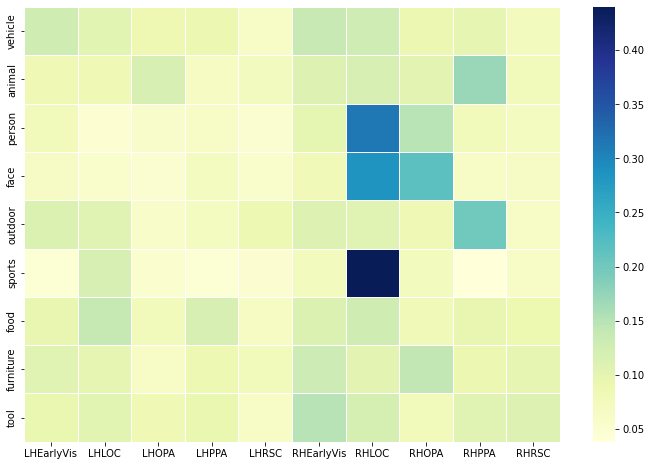

In [5]:
plt.rc('font', size=10)
fig, ax = plt.subplots()
fig.set_size_inches(12, 8)
all_wts = np.round(np.array(all_wts), decimals=3)
print(sub)
print(all_wts)
ax = sns.heatmap(all_wts, linewidth=0.5, cmap="YlGnBu")
ax.set_xticklabels(roi_names)
ax.set_yticklabels(names)
plt.show()

In [6]:
sub = subjs[1]
roi_names, dataset = get_dataset(sub)
all_wts = []
for idx, j in enumerate(js):
    model, train, attn = get_attn(dataset, j, n_epochs)
    print('************************************')
    print(names[idx])
    wts = get_wts(train, attn)
    print(wts)
    print('************************************')
    all_wts.append(wts)

Epoch 1/50
287/287 [==============================] - 5s 16ms/step - loss: 0.4886 - categorical_accuracy: 0.8216
Epoch 2/50
287/287 [==============================] - 5s 16ms/step - loss: 0.4356 - categorical_accuracy: 0.8310
Epoch 3/50
287/287 [==============================] - 4s 15ms/step - loss: 0.4225 - categorical_accuracy: 0.8334
Epoch 4/50
287/287 [==============================] - 4s 15ms/step - loss: 0.4157 - categorical_accuracy: 0.8334
Epoch 5/50
287/287 [==============================] - 4s 15ms/step - loss: 0.3972 - categorical_accuracy: 0.8380
Epoch 6/50
287/287 [==============================] - 4s 15ms/step - loss: 0.3898 - categorical_accuracy: 0.8425
Epoch 7/50
287/287 [==============================] - 4s 15ms/step - loss: 0.3908 - categorical_accuracy: 0.8362
Epoch 8/50
287/287 [==============================] - 4s 15ms/step - loss: 0.3842 - categorical_accuracy: 0.8380
Epoch 9/50
287/287 [==============================] - 4s 15ms/step - loss: 0.3763 - categorical_

CSI2
[[0.123 0.086 0.074 0.101 0.08  0.133 0.079 0.119 0.139 0.067]
 [0.1   0.066 0.077 0.094 0.072 0.118 0.079 0.12  0.206 0.069]
 [0.089 0.041 0.055 0.085 0.057 0.091 0.07  0.367 0.103 0.041]
 [0.087 0.046 0.05  0.073 0.061 0.057 0.073 0.424 0.085 0.046]
 [0.143 0.095 0.067 0.115 0.071 0.174 0.103 0.058 0.137 0.037]
 [0.091 0.076 0.074 0.118 0.075 0.118 0.09  0.164 0.134 0.059]
 [0.124 0.075 0.092 0.107 0.092 0.12  0.084 0.136 0.098 0.072]
 [0.132 0.064 0.067 0.12  0.07  0.115 0.088 0.112 0.165 0.067]
 [0.134 0.058 0.072 0.137 0.072 0.117 0.085 0.123 0.14  0.062]]


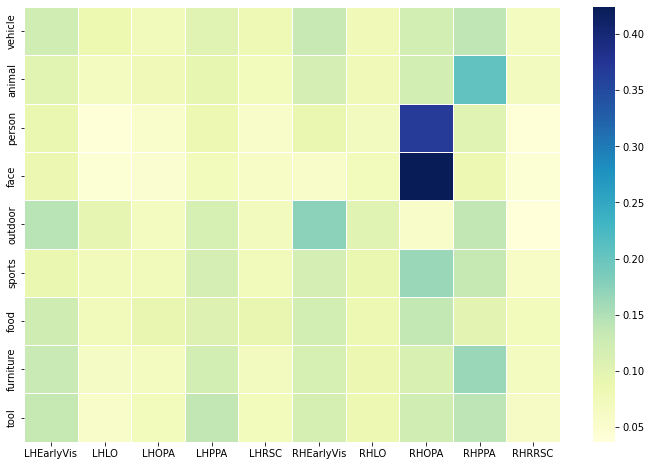

In [7]:
plt.rc('font', size=10)
fig, ax = plt.subplots()
fig.set_size_inches(12, 8)
all_wts = np.round(np.array(all_wts), decimals=3)
print(sub)
print(all_wts)
ax = sns.heatmap(all_wts, linewidth=0.5, cmap="YlGnBu")
ax.set_xticklabels(roi_names)
ax.set_yticklabels(names)
plt.show()

In [8]:
sub = subjs[2]
roi_names, dataset = get_dataset(sub)
all_wts = []
for idx, j in enumerate(js):
    model, train, attn = get_attn(dataset, j, n_epochs)
    print('************************************')
    print(names[idx])
    wts = get_wts(train, attn)
    print(wts)
    print('************************************')
    all_wts.append(wts)

Epoch 1/50
287/287 [==============================] - 5s 17ms/step - loss: 0.4864 - categorical_accuracy: 0.8194
Epoch 2/50
287/287 [==============================] - 4s 16ms/step - loss: 0.4210 - categorical_accuracy: 0.8291
Epoch 3/50
287/287 [==============================] - 4s 15ms/step - loss: 0.3932 - categorical_accuracy: 0.8382
Epoch 4/50
287/287 [==============================] - 4s 15ms/step - loss: 0.3757 - categorical_accuracy: 0.8456
Epoch 5/50
287/287 [==============================] - 4s 15ms/step - loss: 0.3590 - categorical_accuracy: 0.8501
Epoch 6/50
287/287 [==============================] - 4s 15ms/step - loss: 0.3465 - categorical_accuracy: 0.8599
Epoch 7/50
287/287 [==============================] - 4s 15ms/step - loss: 0.3388 - categorical_accuracy: 0.8630
Epoch 8/50
287/287 [==============================] - 4s 15ms/step - loss: 0.3261 - categorical_accuracy: 0.8630
Epoch 9/50
287/287 [==============================] - 4s 15ms/step - loss: 0.3085 - categorical_

CSI3
[[0.243 0.061 0.098 0.092 0.071 0.08  0.072 0.097 0.107 0.078]
 [0.109 0.066 0.09  0.076 0.08  0.077 0.239 0.087 0.104 0.072]
 [0.129 0.048 0.062 0.066 0.055 0.058 0.369 0.068 0.067 0.077]
 [0.067 0.042 0.054 0.056 0.055 0.049 0.509 0.048 0.058 0.064]
 [0.157 0.072 0.085 0.134 0.116 0.098 0.087 0.092 0.089 0.069]
 [0.093 0.07  0.077 0.089 0.081 0.072 0.261 0.064 0.098 0.095]
 [0.38  0.056 0.072 0.05  0.051 0.068 0.05  0.125 0.094 0.053]
 [0.196 0.068 0.095 0.094 0.088 0.083 0.088 0.114 0.087 0.089]
 [0.16  0.078 0.142 0.088 0.082 0.076 0.078 0.08  0.11  0.107]]


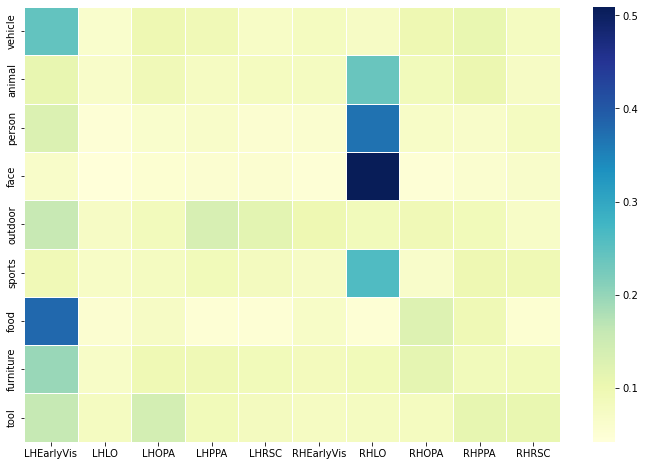

In [9]:
plt.rc('font', size=10)
fig, ax = plt.subplots()
fig.set_size_inches(12, 8)
all_wts = np.round(np.array(all_wts), decimals=3)
print(sub)
print(all_wts)
ax = sns.heatmap(all_wts, linewidth=0.5, cmap="YlGnBu")
ax.set_xticklabels(roi_names)
ax.set_yticklabels(names)
plt.show()

In [10]:
sub = subjs[3]
roi_names, dataset = get_dataset(sub)
all_wts = []
for idx, j in enumerate(js):
    model, train, attn = get_attn(dataset, j, n_epochs)
    print('************************************')
    print(names[idx])
    wts = get_wts(train, attn)
    print(wts)
    print('************************************')
    all_wts.append(wts)

Epoch 1/50
171/171 [==============================] - 3s 17ms/step - loss: 0.5289 - categorical_accuracy: 0.7813
Epoch 2/50
171/171 [==============================] - 3s 15ms/step - loss: 0.4194 - categorical_accuracy: 0.8319
Epoch 3/50
171/171 [==============================] - 2s 15ms/step - loss: 0.3842 - categorical_accuracy: 0.8401
Epoch 4/50
171/171 [==============================] - 2s 15ms/step - loss: 0.3733 - categorical_accuracy: 0.8448
Epoch 5/50
171/171 [==============================] - 3s 15ms/step - loss: 0.3338 - categorical_accuracy: 0.8560
Epoch 6/50
171/171 [==============================] - 3s 15ms/step - loss: 0.3240 - categorical_accuracy: 0.8542
Epoch 7/50
171/171 [==============================] - 2s 15ms/step - loss: 0.2952 - categorical_accuracy: 0.8777
Epoch 8/50
171/171 [==============================] - 2s 14ms/step - loss: 0.2934 - categorical_accuracy: 0.8665
Epoch 9/50
171/171 [==============================] - 2s 14ms/step - loss: 0.2631 - categorical_

CSI4
[[0.136 0.147 0.091 0.09  0.053 0.157 0.103 0.107 0.059 0.056]
 [0.107 0.318 0.048 0.055 0.068 0.069 0.146 0.061 0.065 0.065]
 [0.079 0.11  0.06  0.053 0.032 0.069 0.439 0.063 0.053 0.043]
 [0.061 0.065 0.049 0.038 0.023 0.047 0.554 0.044 0.083 0.036]
 [0.11  0.143 0.049 0.139 0.046 0.141 0.19  0.051 0.071 0.06 ]
 [0.091 0.231 0.055 0.063 0.046 0.067 0.267 0.066 0.055 0.058]
 [0.045 0.147 0.115 0.061 0.04  0.092 0.33  0.077 0.045 0.047]
 [0.102 0.127 0.07  0.094 0.057 0.093 0.253 0.062 0.059 0.083]
 [0.1   0.209 0.13  0.092 0.05  0.117 0.068 0.084 0.07  0.081]]


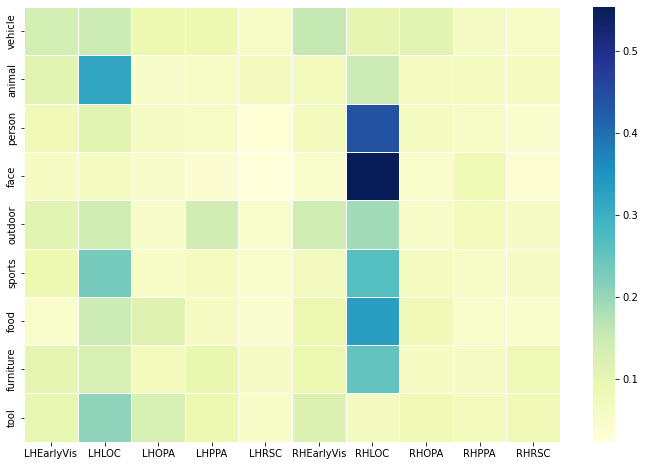

In [11]:
plt.rc('font', size=10)
fig, ax = plt.subplots()
fig.set_size_inches(12, 8)
all_wts = np.round(np.array(all_wts), decimals=3)
print(sub)
print(all_wts)
ax = sns.heatmap(all_wts, linewidth=0.5, cmap="YlGnBu")
ax.set_xticklabels(roi_names)
ax.set_yticklabels(names)
plt.show()